In [21]:
import os

import torch
from torch import nn
from torchvision import transforms
import torchvision
from torchinfo import summary

from pathlib import Path

import matplotlib.pyplot as plt

from going_modular import data_setup, engine

from helper_functions import download_data, set_seeds, plot_loss_curves

In [10]:
# Data Path
indian_food_path = Path("data")
indian_food_image_path = indian_food_path / "indian_food"

### Training My personal EffnetB2 model on Indian Food for classification

In [2]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### 1. Getting the data

In [11]:
# Setup directory paths to train and test images
indian_train_dir = indian_food_image_path / "train"
indian_test_dir = indian_food_image_path / "test"

In [12]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [39]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=indian_train_dir,
    test_dir=indian_test_dir,
    train_transform=manual_transforms, # use manually created transforms
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)


In [40]:
len(class_names)

55

### 2. Initializing the effnetb2 model

In [41]:
# Get the effnetb2 model
from going_modular import model_selection
effnetb2, effnetb2_transforms = model_selection.create_model(model_name="effnetb2",out_features=len(class_names),seed=42, device=device)
# effnetb2
effnetb2

[INFO] Creating effnetb2 feature extractor model...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
indian_food_train_transforms_for_effnetb2 = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

indian_food_test_transforms_for_effnetb2 = torchvision.transforms.Compose([
    #torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])


In [43]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small
NUM_WORKERS = 1 if os.cpu_count() <= 4 else 4 # This is the optimum not more than 4 works fine
# Create data loaders
indian_train_dataloader, indian_test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=indian_train_dir,
    test_dir=indian_test_dir,
    train_transform=indian_food_train_transforms_for_effnetb2, # Added Trivial augment for training
    test_transform=indian_food_test_transforms_for_effnetb2, # Added simple transfor of the model
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [44]:
len(indian_train_dataloader), len(indian_test_dataloader), len(class_names)

(723, 164, 55)

#### 3. Training the model on indian data

In [45]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer 
optimizer = torch.optim.AdamW(params=effnetb2.parameters(),
                             lr=1e-3,
                             weight_decay=0.01)

In [46]:


# Train the model
set_seeds()
effnetb2_indian_food_results = engine.train(model=effnetb2,
                                              train_dataloader=indian_train_dataloader,
                                              test_dataloader=indian_test_dataloader,
                                              epochs=50,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2700 | train_acc: 0.5490 | test_loss: 1.7502 | test_acc: 0.6963
Epoch: 2 | train_loss: 1.8056 | train_acc: 0.6636 | test_loss: 1.6554 | test_acc: 0.7191
Epoch: 3 | train_loss: 1.7495 | train_acc: 0.6809 | test_loss: 1.6235 | test_acc: 0.7244
Epoch: 4 | train_loss: 1.7263 | train_acc: 0.6892 | test_loss: 1.5969 | test_acc: 0.7315
Epoch: 5 | train_loss: 1.7022 | train_acc: 0.6989 | test_loss: 1.6081 | test_acc: 0.7270
Epoch: 6 | train_loss: 1.6943 | train_acc: 0.7020 | test_loss: 1.5861 | test_acc: 0.7325
Epoch: 7 | train_loss: 1.6884 | train_acc: 0.7065 | test_loss: 1.5846 | test_acc: 0.7377
Epoch: 8 | train_loss: 1.6777 | train_acc: 0.7070 | test_loss: 1.5803 | test_acc: 0.7397
Epoch: 9 | train_loss: 1.6728 | train_acc: 0.7093 | test_loss: 1.5719 | test_acc: 0.7449
Epoch: 10 | train_loss: 1.6778 | train_acc: 0.7062 | test_loss: 1.5689 | test_acc: 0.7405
Epoch: 11 | train_loss: 1.6696 | train_acc: 0.7110 | test_loss: 1.5586 | test_acc: 0.7477
Epoch: 12 | train_l

In [ ]:
# Epoch: 1 | train_loss: 2.2693 | train_acc: 0.5431 | test_loss: 2.0105 | test_acc: 0.6144
# Epoch: 2 | train_loss: 1.5595 | train_acc: 0.7474 | test_loss: 1.7039 | test_acc: 0.6954
# Epoch: 3 | train_loss: 1.4087 | train_acc: 0.7839 | test_loss: 1.6218 | test_acc: 0.7043
# Epoch: 4 | train_loss: 1.3297 | train_acc: 0.8092 | test_loss: 1.5756 | test_acc: 0.7217
# Epoch: 5 | train_loss: 1.2870 | train_acc: 0.8225 | test_loss: 1.5205 | test_acc: 0.7434

# Epoch: 1 | train_loss: 1.1303 | train_acc: 0.8816 | test_loss: 1.4710 | test_acc: 0.7503
# Epoch: 2 | train_loss: 1.1354 | train_acc: 0.8795 | test_loss: 1.4367 | test_acc: 0.7605
# Epoch: 3 | train_loss: 1.1491 | train_acc: 0.8673 | test_loss: 1.4591 | test_acc: 0.7466
# Epoch: 4 | train_loss: 1.1329 | train_acc: 0.8793 | test_loss: 1.4505 | test_acc: 0.7526
# Epoch: 5 | train_loss: 1.1298 | train_acc: 0.8816 | test_loss: 1.4304 | test_acc: 0.7538

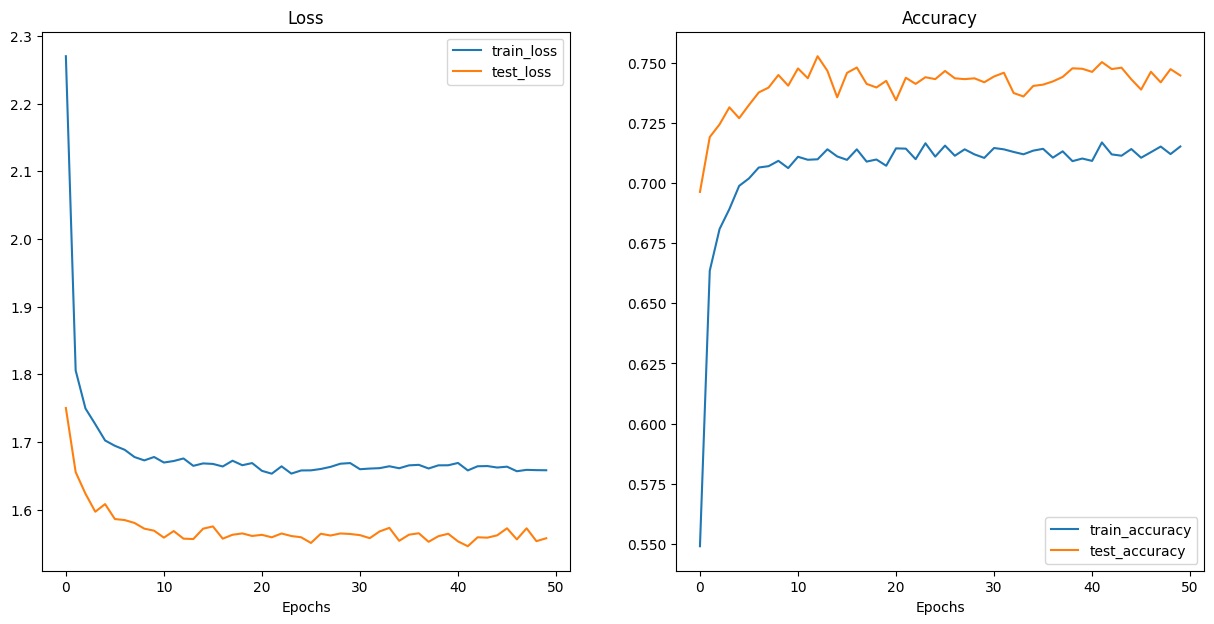

In [47]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_indian_food_results)

In [48]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "indian_food_model_v2.pth" 

# Save FoodVision Big model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models\indian_food_model_v2.pth


#### Predicting on all the dataset of tests

In [49]:
# If you have a test folder with images already we can use datasets ImageFolder to create a dataset
from torchvision import datasets
indian_test_data = datasets.ImageFolder(root=indian_test_dir,
                                 transform=indian_food_test_transforms_for_effnetb2
                                 )

In [50]:
len(indian_test_data)

5243

In [51]:
from torch.utils.data import DataLoader
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
indian_test_dataloader_all_data_batch_size_1 = DataLoader(indian_test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

len(indian_test_dataloader_all_data_batch_size_1)

5243

In [52]:
from tqdm.auto import tqdm
# Prepare model (do this outside the loop)
effnetb2 = effnetb2.to(device)
effnetb2.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
indian_all_test_data_pred_list = []
for X, y in tqdm(indian_test_dataloader_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)
  
  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {} 

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]
  
  indian_all_test_data_pred_list.append(pred_dict)

  0%|          | 0/5243 [00:07<?, ?it/s]

In [53]:
import pandas as pd
# Create DataFrame with various columns
indian_all_test_data_df = pd.DataFrame(indian_all_test_data_pred_list)

# Create a column for if the prediction is correct
indian_all_test_data_df["is_correct"] = indian_all_test_data_df["pred_label"] == indian_all_test_data_df["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
indian_all_test_data_df["pred_class"] = indian_all_test_data_df["pred_label"].apply(lambda x: class_names[x])
indian_all_test_data_df["label_class"] = indian_all_test_data_df["label"].apply(lambda x: class_names[x])
indian_all_test_data_df.head()

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.4322059,0,0,True,biriyani,biriyani
1,0.5047869,0,0,True,biriyani,biriyani
2,0.71366525,0,0,True,biriyani,biriyani
3,0.93842643,0,0,True,biriyani,biriyani
4,0.9827539,0,0,True,biriyani,biriyani


In [54]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
indian_all_test_data_df[indian_all_test_data_df["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
43,0.97343326,54,2,False,waffles,burger
4649,0.96703064,13,49,False,cup_cakes,strawberry_shortcake
3308,0.96182084,22,29,False,frozen_yogurt,ice_cream
1785,0.9525721,39,19,False,onion_rings,fish_and_chips
1707,0.9449553,39,19,False,onion_rings,fish_and_chips
2064,0.9430255,37,20,False,nachos,french_fries
1285,0.93167436,39,16,False,onion_rings,donuts
2745,0.92737246,23,25,False,garlic_bread,grilled_cheese_sandwich
2300,0.9041543,29,22,False,ice_cream,frozen_yogurt
4872,0.89784443,46,50,False,ramen,tacos


In [55]:
# import pandas as pd
# # Evalaute model on entire test set
# indian_all_test_data_df = pd.DataFrame(indian_all_test_data_pred_list)
# indian_all_test_data_df["is_correct"] = indian_all_test_data_df["pred_label"] == indian_all_test_data_df["label"]
indian_all_test_data_df.is_correct.value_counts()

is_correct
True     3904
False    1339
Name: count, dtype: int64

In [56]:
indian_all_test_data_df.head(20)

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.4322059,0,0,True,biriyani,biriyani
1,0.5047869,0,0,True,biriyani,biriyani
2,0.71366525,0,0,True,biriyani,biriyani
3,0.93842643,0,0,True,biriyani,biriyani
4,0.9827539,0,0,True,biriyani,biriyani
5,0.56145996,0,0,True,biriyani,biriyani
6,0.36824965,17,0,False,dosa,biriyani
7,0.23159009,37,0,False,nachos,biriyani
8,0.22440687,32,0,False,kadai_paneer,biriyani
9,0.30332148,21,0,False,fried_rice,biriyani


In [57]:
# Create path to Indian class names
foodeye_big_class_names_path = indian_food_image_path / "indian_class_names.txt"

# Write Indian class names list to file
with open(foodeye_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodeye_big_class_names_path}")
    f.write("\n".join(class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to data\indian_food\indian_class_names.txt
